In [1]:
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from tqdm import tqdm  # to visualize progress

from PMCPnP import PMCPnPAnnealing, PMCPnP
from utils import get_blur_physics, get_inpainting_physics

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = get_image_url("butterfly.png")
img_size = 256
x_true = load_url_image(url=url, img_size=img_size).to(device)
x = x_true.clone()

/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Selected GPU 0 with 24128 MB free memory 


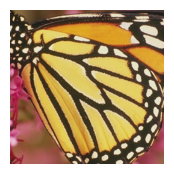

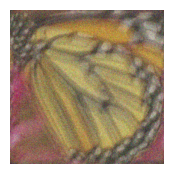

In [4]:
sigma = 0.1  # noise level

physics = get_blur_physics(sigma, device)

#physics = get_inpainting_physics(img_size, sigma, device)

torch.manual_seed(0)

# load Gaussian Likelihood
likelihood = dinv.optim.L2(sigma=sigma)

prior = dinv.optim.ScorePrior(
    denoiser=dinv.models.DnCNN(pretrained="download_lipschitz")
    #denoiser=dinv.models.DiffUNet(large_model=False)
).to(device)

y = physics(x)
plot(x_true.detach().cpu())
plot(y)

In [9]:
gamma = 1.e-4
alpha = 1
iterations = int(2e3) if torch.cuda.is_available() else 10
sigma_denoiser = 0.1


pmc_pnp = PMCPnP(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,)




  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:17<00:00, 115.05it/s]


Monte Carlo sampling finished! elapsed time=17.44 seconds
Iteration 1999, current converge crit. = 2.94E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.75 dB
PreconULA posterior mean PSNR: 12.47 dB


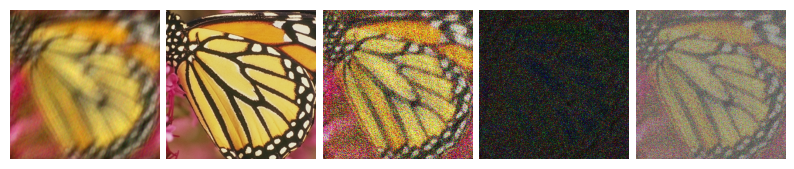

In [10]:

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)


# plot results
imgs = [x_lin, x, pula_mean, pula_var, example_sample]
plot(imgs)

In [195]:
iterations = int(3e3) if torch.cuda.is_available() else 10
gamma = 0.0001

xsi = 0.99

base_sigma = 368 / 255
min_sigma = 0.1
base_alpha = 1 / (min_sigma**2)
min_alpha = 1
sigmas = torch.Tensor([max(base_sigma * (xsi**i) , min_sigma) for i in range(iterations)])
alphas = torch.Tensor([max(base_alpha * (elem**2), min_alpha) for elem in sigmas])


pmc_pnp = PMCPnPAnnealing(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigmas=sigmas,
                 alphas=alphas,)




  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:25<00:00, 115.68it/s]


Monte Carlo sampling finished! elapsed time=25.99 seconds
Iteration 2999, current converge crit. = 1.54E-04, objective = 1.00E-03 
Iteration 2999, current converge crit. = 9.61E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 13.06 dB
PreconULA posterior mean PSNR: 0.65 dB


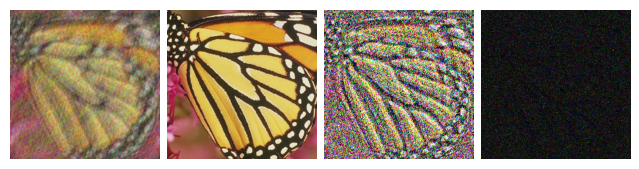

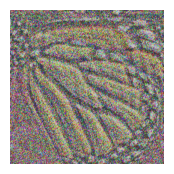

In [196]:

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

# plot results
imgs = [x_lin, x, pula_mean, pula_var]
plot(imgs)
example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)

plot(example_sample)


# test

In [189]:
denoiser = dinv.models.DRUNet(pretrained="download")
denoiser = dinv.models.DiffUNet(pretrained='download', large_model=False)

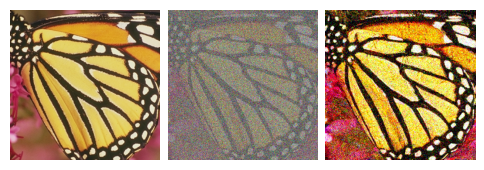

In [193]:
noise = dinv.physics.GaussianNoise(sigma=0.5)

y = noise(x)

out = denoiser.forward_denoise(y.cpu(), 0.5)

plot([x, y, out])